In [1]:
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
import scipy.signal
import pickle
import multigoal

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class Policy(object):
    def __init__(self, obs_dim, act_dim, kl_targ,n_mixture=4):
        """
        Args:
            obs_dim: num observation dimensions (int)
            act_dim: num action dimensions (int)
            kl_targ: target KL divergence between pi_old and pi_new
        """
        self.beta = 1.0  # dynamically adjusted D_KL loss multiplier
        self.eta = 100  # multiplier for D_KL-kl_targ hinge-squared loss
        self.kl_targ = kl_targ
        self.epochs = 20
        self.lr = None
        self.lr_multiplier = 1.0  # dynamically adjust lr when D_KL out of control
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.n_mixture = n_mixture
        self.max_std = 0.003
        self._build_graph()
        self._init_session()

    def _build_graph(self):
        """ Build and initialize TensorFlow graph """
        self.g = tf.Graph()
        with self.g.as_default():
            self._placeholders()
            self._policy_nn()
            self._logprob()
            self._kl_entropy()
            self._loss_train_op()
            self.init = tf.global_variables_initializer()
            self.variables = tf.global_variables()
            
    def _placeholders(self):
        """ Input placeholders"""
        # observations, actions and advantages:
        self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs')
        self.act_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'act')
        self.advantages_ph = tf.placeholder(tf.float32, (None,), 'advantages')
        # strength of D_KL loss terms:
        self.beta_ph = tf.placeholder(tf.float32, (), 'beta')
        self.eta_ph = tf.placeholder(tf.float32, (), 'eta')
        # learning rate:
        self.lr_ph = tf.placeholder(tf.float32, (), 'eta')
        
        self.old_std_ph = tf.placeholder(tf.float32, (None, self.act_dim, self.n_mixture), 'old_std')
        self.old_means_ph = tf.placeholder(tf.float32, (None, self.act_dim, self.n_mixture), 'old_means')
        self.old_pi_ph = tf.placeholder(tf.float32, (None, self.n_mixture), 'old_pi')
    
    def _policy_nn(self):
        
        hid1_size = 64  # 10 empirically determined
        hid2_size = 64
        
        self.lr = 3e-4  # 9e-4 empirically determined
        out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.01), name="h1")
        out = tf.layers.dense(out, hid2_size, tf.tanh,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.01), name="h2")
        means = tf.layers.dense(out, self.act_dim*self.n_mixture,
                                kernel_initializer=tf.random_normal_initializer(stddev=0.01), 
#                                 bias_initializer=tf.random_uniform_initializer(minval=-1.0,maxval=1.0), 
                                name="flat_means")
        self.means = tf.reshape(means,shape=[-1,self.act_dim,self.n_mixture], name="means")
        
#         logits_std = tf.get_variable('logstd', [1, self.act_dim, self.n_mixture], tf.float32, tf.constant_initializer(-1.0))
        logits_std = tf.layers.dense(out, self.act_dim*self.n_mixture,
                                kernel_initializer=tf.random_normal_initializer(stddev=0.01), 
                                name="flat_logits_std")
        self.std = tf.reshape(self.max_std*tf.sigmoid(logits_std),shape=[-1,self.act_dim,self.n_mixture], name="std")

        self.pi = tf.nn.softmax(tf.layers.dense(out, self.n_mixture,
                                                kernel_initializer=tf.random_normal_initializer(stddev=0.01), name="pi"))
        
    def _logprob(self):
        """ Calculate log probabilities of a batch of observations & actions
        Calculates log probabilities using previous step's model parameters and
        new parameters being trained.
        """
        y = self.act_ph 
        mu = self.means
        sigma = self.std
        pi = self.pi
        
        quadratics = -0.5*tf.reduce_sum(tf.square((tf.tile(y[:,:,tf.newaxis],[1,1,self.n_mixture])-mu)/sigma),axis=1)
        logdet = -0.5*tf.reduce_sum(tf.log(sigma),axis=1)
        logconstant = - 0.5*self.act_dim*np.log(2.*np.pi)
        logpi = tf.log(pi)
        
        exponents = quadratics + logdet + logconstant + logpi
        logprobs = tf.reduce_logsumexp(exponents,axis=1)
        
        self.logp = logprobs

        old_sigma_ph = self.old_std_ph
        old_mu_ph = self.old_means_ph
        old_pi_ph = self.old_pi_ph
    
        quadratics = -0.5*tf.reduce_sum(tf.square((tf.tile(y[:,:,tf.newaxis],[1,1,self.n_mixture])-old_mu_ph)/old_sigma_ph),axis=1)
        logdet = -0.5*tf.reduce_sum(tf.log(old_sigma_ph),axis=1)
        logconstant = - 0.5*self.act_dim*np.log(2.*np.pi)
        logpi = tf.log(old_pi_ph)
        
        exponents = quadratics + logdet + logconstant + logpi
        old_logprobs = tf.reduce_logsumexp(exponents,axis=1)
        
        self.logp_old = old_logprobs
    
    def _kl_entropy(self):
        """
        Add to Graph:
            1. KL divergence between old and new distributions
            2. Entropy of present policy given states and actions
        https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Kullback.E2.80.93Leibler_divergence
        https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Entropy
        """
        log_det_cov_old = tf.reduce_sum(tf.log(self.old_std_ph),axis=1)
        log_det_cov_new = tf.reduce_sum(tf.log(self.std),axis=1)
        tr_old_new = tf.reduce_sum(self.old_std_ph/self.std,axis=1)

        self.kl = tf.reduce_sum(self.old_pi_ph*tf.log(self.old_pi_ph/self.pi) + 0.5 * self.old_pi_ph*(log_det_cov_new - log_det_cov_old + tr_old_new +
                         tf.reduce_sum(tf.square((self.means - self.old_means_ph)/self.std),axis=1) - self.act_dim),axis=1)
        self.kl = tf.reduce_mean(self.kl)
        
        self.entropy = tf.reduce_sum(self.pi*(-tf.log(self.pi) + 0.5 * (self.act_dim * (np.log(2 * np.pi) + 1) +
                              tf.reduce_sum(tf.log(self.std),axis=1))),axis=1)
        self.entropy = tf.reduce_mean(self.entropy)

    def _loss_train_op(self):
        """
        Three loss terms:
            1) standard policy gradient
            2) D_KL(pi_old || pi_new)
            3) Hinge loss on [D_KL - kl_targ]^2
        See: https://arxiv.org/pdf/1707.02286.pdf
        """
        loss1 = -tf.reduce_mean(self.advantages_ph *
                                tf.exp(self.logp - self.logp_old))
        loss2 = tf.reduce_mean(self.beta_ph * self.kl)
        loss3 = self.eta_ph * tf.square(tf.maximum(0.0, self.kl - 2.0 * self.kl_targ))
#         loss4
#         loss4 = 0.01*tf.reduce_mean(self.logp)
#         self.loss = loss1 + loss2 + loss3 + loss4
        self.loss = loss1 + loss2 + loss3
        self.loss_p = -tf.reduce_mean(self.logp)
        
        optimizer = tf.train.AdamOptimizer(self.lr_ph)
        self.train_op = optimizer.minimize(self.loss)
        self.train_p_op = optimizer.minimize(self.loss_p)

    def _init_session(self):
        """Launch TensorFlow session and initialize variables"""
        self.sess = tf.Session(graph=self.g)
        self.sess.run(self.init)

    def sample(self, obs):
        """Draw sample from policy distribution"""
        feed_dict = {self.obs_ph: obs}

        pi, mu, sigma = self.sess.run([self.pi, self.means, self.std],feed_dict=feed_dict)
        
        n_points = np.shape(obs)[0]
        
        _y_sampled = np.zeros([n_points,self.act_dim])
        for i in range(n_points):
            k = np.random.choice(self.n_mixture,p=pi[i,:])
            _y_sampled[i,:] = mu[i,:,k] + np.random.randn(1,self.act_dim)*sigma[i,:,k]
        return _y_sampled
    
    def update(self, observes, actions, advantages, batch_size = 128):
        
        num_batches = max(observes.shape[0] // batch_size, 1)
        batch_size = observes.shape[0] // num_batches
        
        old_means_np, old_std_np, old_pi_np = self.sess.run([self.means, self.std, self.pi],{self.obs_ph: observes})
        loss, kl, entropy = 0, 0, 0
        for e in range(self.epochs):
            # TODO: need to improve data pipeline - re-feeding data every epoch
            observes, actions, advantages, old_means_np, old_std_np, old_pi_np = shuffle(observes, actions, advantages, old_means_np, old_std_np, old_pi_np)
            for j in range(num_batches):
                start = j * batch_size
                end = (j + 1) * batch_size
                feed_dict = {self.obs_ph: observes[start:end,:],
                     self.act_ph: actions[start:end,:],
                     self.advantages_ph: advantages[start:end],
                     self.old_std_ph: old_std_np[start:end,:,:],
                     self.old_means_ph: old_means_np[start:end,:,:],
                     self.old_pi_ph: old_pi_np[start:end,:],
                     self.beta_ph: self.beta,
                     self.eta_ph: self.eta,
                     self.lr_ph: self.lr * self.lr_multiplier}
        
                self.sess.run(self.train_op, feed_dict)
            loss, kl, entropy = self.sess.run([self.loss, self.kl, self.entropy], feed_dict)
            if kl > self.kl_targ * 4:  # early stopping if D_KL diverges badly
                break
        # TODO: too many "magic numbers" in next 8 lines of code, need to clean up
        if kl > self.kl_targ * 2:  # servo beta to reach D_KL target
            self.beta = np.minimum(35, 1.5 * self.beta)  # max clip beta
            if self.beta > 30 and self.lr_multiplier > 0.1:
                self.lr_multiplier /= 1.5
        elif kl < self.kl_targ / 2:
            self.beta = np.maximum(1 / 35, self.beta / 1.5)  # min clip beta
            if self.beta < (1 / 30) and self.lr_multiplier < 10:
                self.lr_multiplier *= 1.5
        
        loss, kl, entropy = self.sess.run([self.loss, self.kl, self.entropy], feed_dict)
        return loss, kl, entropy
    
    def fit(self, x, y, batch_size=128):
        """ Fit model to current data batch + previous data batch
        Args:
            x: features
            y: target
            logger: logger to save training loss and % explained variance
        """
        num_batches = max(x.shape[0] // batch_size, 1)
        batch_size = x.shape[0] // num_batches
        
        x_train = x
        y_train = y
        for e in range(self.epochs):
            x_train, y_train = shuffle(x_train, y_train)
            for j in range(num_batches):
                start = j * batch_size
                end = (j + 1) * batch_size
                feed_dict = {self.obs_ph: x_train[start:end, :],
                             self.act_ph: y_train[start:end, :],
                             self.lr_ph: self.lr}
                _, l = self.sess.run([self.train_p_op, self.loss_p], feed_dict=feed_dict)
        feed_dict = {self.obs_ph: x_train, self.act_ph: y_train, self.lr_ph: self.lr}
        loss_p = self.sess.run(self.loss_p, feed_dict=feed_dict)
        return loss_p
    
    def save_policy(self, path):
        saver = tf.train.Saver(self.variables)
        saver.save(self.sess, path+'/mdn'+str(self.n_mixture)+'_bc_policy.ckpt')

    def close_sess(self):
        """ Close TensorFlow session """
        self.sess.close()

In [3]:
class NNValueFunction(object):
    """ NN-based state-value function """
    def __init__(self, obs_dim):
        """
        Args:
            obs_dim: number of dimensions in observation vector (int)
        """
        self.replay_buffer_x = None
        self.replay_buffer_y = None
        self.obs_dim = obs_dim
        self.epochs = 20
        self.lr = None  # learning rate set in _build_graph()
        self._build_graph()
        self.sess = tf.Session(graph=self.g)
        self.sess.run(self.init)

    def _build_graph(self):
        """ Construct TensorFlow graph, including loss function, init op and train op """
        self.g = tf.Graph()
        with self.g.as_default():
            self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs_valfunc')
            self.val_ph = tf.placeholder(tf.float32, (None,), 'val_valfunc')
            # hid1 layer size is 10x obs_dim, hid3 size is 10, and hid2 is geometric mean
            hid1_size = 64
            hid2_size = 64
            self.lr = 1e-3
            
            out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(
                                      stddev=0.01), name="h1")
            out = tf.layers.dense(out, hid2_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(
                                      stddev=0.01), name="h2")
            out = tf.layers.dense(out, 1,
                                  kernel_initializer=tf.random_normal_initializer(
                                      stddev=0.01), name='output')
            self.out = tf.squeeze(out)
            self.loss = tf.reduce_mean(tf.square(self.out - self.val_ph))
            optimizer = tf.train.AdamOptimizer(self.lr)
            self.train_op = optimizer.minimize(self.loss)
            self.init = tf.global_variables_initializer()
        self.sess = tf.Session(graph=self.g)
        self.sess.run(self.init)

    def fit(self, x, y, batch_size=32):
        """ Fit model to current data batch + previous data batch
        Args:
            x: features
            y: target
            logger: logger to save training loss and % explained variance
        """
        num_batches = max(x.shape[0] // batch_size, 1)
        y_hat = self.predict(x)  # check explained variance prior to update
        
        if self.replay_buffer_x is None:
            x_train, y_train = x, y
        else:
            x_train = np.concatenate([x, self.replay_buffer_x])
            y_train = np.concatenate([y, self.replay_buffer_y])
        self.replay_buffer_x = x
        self.replay_buffer_y = y
        for e in range(self.epochs):
            x_train, y_train = shuffle(x_train, y_train)
            for j in range(num_batches):
                start = j * batch_size
                end = (j + 1) * batch_size
                feed_dict = {self.obs_ph: x_train[start:end, :],
                             self.val_ph: y_train[start:end]}
                _, l = self.sess.run([self.train_op, self.loss], feed_dict=feed_dict)
        y_hat = self.predict(x)
        loss = np.mean(np.square(y_hat - y))         # explained variance after update
        return loss

    def predict(self, x):
        """ Predict method """
        feed_dict = {self.obs_ph: x}
        y_hat = self.sess.run(self.out, feed_dict=feed_dict)

        return np.squeeze(y_hat)

    def close_sess(self):
        """ Close TensorFlow session """
        self.sess.close()

In [4]:

def discount(x, gamma):
    """ Calculate discounted forward sum of a sequence at each point """
    return scipy.signal.lfilter([1.0], [1.0, -gamma], x[::-1])[::-1]


def add_disc_sum_rew(trajectories, gamma):
    """ Adds discounted sum of rewards to all time steps of all trajectories
    Args:
        trajectories: as returned by run_policy()
        gamma: discount
    Returns:
        None (mutates trajectories dictionary to add 'disc_sum_rew')
    """
    for trajectory in trajectories:
        if gamma < 0.999:  # don't scale for gamma ~= 1
            rewards = trajectory['rewards'] * (1 - gamma)
        else:
            rewards = trajectory['rewards']
        disc_sum_rew = discount(rewards, gamma)
        trajectory['disc_sum_rew'] = disc_sum_rew

def add_rew(trajectories):
    for trajectory in trajectories:
        trajectory['rewards'] = trajectory['true_rewards']

def add_value(trajectories, val_func):
    """ Adds estimated value to all time steps of all trajectories
    Args:
        trajectories: as returned by run_policy()
        val_func: object with predict() method, takes observations
            and returns predicted state value
    Returns:
        None (mutates trajectories dictionary to add 'values')
    """
    for trajectory in trajectories:
        observes = trajectory['observes']
        values = val_func.predict(observes)
        trajectory['values'] = values


def add_gae(trajectories, gamma, lam):
    for trajectory in trajectories:
        if gamma < 0.999:  # don't scale for gamma ~= 1
            rewards = trajectory['rewards'] * (1 - gamma)
        else:
            rewards = trajectory['rewards']
        values = trajectory['values']
        # temporal differences
        tds = rewards - values + np.append(values[1:] * gamma, 0)
        advantages = discount(tds, gamma * lam)
        trajectory['advantages'] = advantages

def build_train_set(trajectories):
    """
    Args:
        trajectories: trajectories after processing by add_disc_sum_rew(),
            add_value(), and add_gae()
    Returns: 4-tuple of NumPy arrays
        observes: shape = (N, obs_dim)
        actions: shape = (N, act_dim)
        advantages: shape = (N,)
        disc_sum_rew: shape = (N,)
    """
    observes = np.concatenate([t['observes'] for t in trajectories])
    actions = np.concatenate([t['actions'] for t in trajectories])
    disc_sum_rew = np.concatenate([t['disc_sum_rew'] for t in trajectories])
    advantages = np.concatenate([t['advantages'] for t in trajectories])
    # normalize advantages
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-6)

    return observes, actions, advantages, disc_sum_rew

def run_episode(env, policy, animate=False):
    obs = env.reset()
    observes, actions, rewards, infos = [], [], [], []
    done = False
    while not done:
        if animate:
            env.render()
        obs = obs.astype(np.float32).reshape((1, -1))
        observes.append(obs)
        action = policy.sample(obs).reshape((1, -1)).astype(np.float32)
        actions.append(action)
        obs, reward, done, info = env.step(action)
        if not isinstance(reward, float):
            reward = np.asscalar(reward)
        rewards.append(reward)
        infos.append(info)
        
    return (np.concatenate(observes), np.concatenate(actions),
            np.array(rewards, dtype=np.float32), infos)


def run_policy(env, policy, episodes):
    total_steps = 0
    trajectories = []
    for e in range(episodes):
        observes, actions, rewards, infos = run_episode(env, policy)
        total_steps += observes.shape[0]
        trajectory = {'observes': observes,
                      'actions': actions,
                      'true_rewards': rewards,
                      'infos': infos}
        trajectories.append(trajectory)
    return trajectories

In [5]:
demo_file = open('./multigoal_expert_demo.pkl', 'r')
demonstrations, = pickle.load(demo_file)
print('Load {} data'.format(len(demonstrations)))
demonstrations = demonstrations[:10]

env = multigoal.MultiGoalEnv(nr_goal=4)
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
kl_targ = 0.5
gamma = 0.995
lam = 0.98

observes = []
actions = []
for demonstration in demonstrations:
    demonstration['rewards'] = np.asarray(demonstration['rewards'])

exp_ret = np.mean([np.sum(t['rewards']) for t in demonstrations])

policy = Policy(obs_dim,act_dim,kl_targ,n_mixture=4)
val_func = NNValueFunction(obs_dim)

batch_size = 100
nupdates = 10000
        
for update in range(nupdates+1):
    trajectories = run_policy(env, policy, episodes=batch_size)
    add_rew(trajectories)
    add_value(trajectories, val_func)  # add estimated values to episodes
    add_disc_sum_rew(trajectories, gamma)  # calculated discounted sum of Rs
    add_gae(trajectories, gamma, lam)  # calculate advantage
    # concatenate all episodes into single NumPy arrays
    observes, actions, advantages, disc_sum_rew = build_train_set(trajectories)

    pol_loss, pol_kl, pol_entropy = policy.update(observes, actions, advantages,batch_size=512)  # update policy
    vf_loss = val_func.fit(observes, disc_sum_rew,batch_size=512)  # update value function
        
    if (update%50) == 0:
        trajectories = run_policy(env, policy, 100)
        mean_ret = np.mean([t['true_rewards'].sum() for t in trajectories])
        print('*** Mean Ret : {:.3f}/{:.3f}, Value Loss : {:.3f}, Policy loss : {:.3f}, Policy KL : {:.3f}, Policy Entropy : {:.3f} ***'.format(mean_ret, exp_ret, vf_loss, pol_loss, pol_kl, pol_entropy))

Load 1000 data
*** Mean Ret : -5.751/806.053, Value Loss : 0.003, Policy loss : 0.070, Policy KL : 0.004, Policy Entropy : -2.277 ***
*** Mean Ret : -4.254/806.053, Value Loss : 0.004, Policy loss : -0.203, Policy KL : 0.081, Policy Entropy : -2.244 ***
*** Mean Ret : -4.812/806.053, Value Loss : 0.001, Policy loss : -0.144, Policy KL : 0.598, Policy Entropy : -2.236 ***
*** Mean Ret : -1.936/806.053, Value Loss : 0.001, Policy loss : -0.001, Policy KL : 0.200, Policy Entropy : -2.222 ***
*** Mean Ret : -5.183/806.053, Value Loss : 0.009, Policy loss : -0.014, Policy KL : 0.127, Policy Entropy : -2.215 ***
*** Mean Ret : -2.603/806.053, Value Loss : 0.001, Policy loss : -0.025, Policy KL : 0.174, Policy Entropy : -2.202 ***
*** Mean Ret : -4.899/806.053, Value Loss : 0.004, Policy loss : 0.026, Policy KL : 0.024, Policy Entropy : -2.197 ***
*** Mean Ret : -3.940/806.053, Value Loss : 0.001, Policy loss : -0.112, Policy KL : 0.028, Policy Entropy : -2.212 ***
*** Mean Ret : 2.085/806.05

KeyboardInterrupt: 

Evaluation Result: 303.524917858


/usr/local/lib/python2.7/dist-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python2.7/dist-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


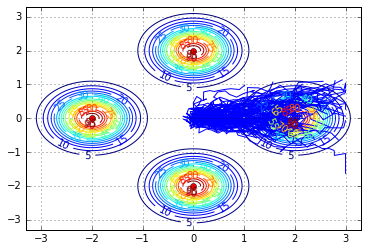

In [6]:
 def evaluation(env, policy, max_eval_epi=100, seed=0):
        return_list = np.zeros((max_eval_epi,))
        info_list = []
        
        env.seed(seed)
        for epi in range(max_eval_epi):
            obs = env.reset()
            env_infos_epi_list = {"pos": [],"goal_id": []}
            observes, actions, rewards, infos = run_episode(env, policy)
            
            pos_list = []
            goal_id_list = []
            for info in infos:
                pos_list.append(info["pos"])
                goal_id_list.append(info["goal_id"])
            env_infos_epi_list["pos"] = np.asarray(pos_list)
            env_infos_epi_list["goal_id"] = np.asarray(goal_id_list)
            
            info_list.append({"env_infos":env_infos_epi_list})
            return_list[epi] = np.sum(rewards)
        print("Evaluation Result: {}".format(np.mean(return_list)))
        return return_list, info_list
    
from matplotlib import pyplot as plt
%matplotlib inline
return_list, info_list = evaluation(env, policy, max_eval_epi=100)
env.plot_paths(info_list)
plt.draw()
plt.pause(0.005)